# King County House Price Prediction - Data Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Loading

In [ ]:
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("harlfoxem/housesalesprediction")
csv_path = Path(path) / "kc_house_data.csv"
print("Dataset downloaded to:", csv_path)

Dataset downloaded to: /home/avidaldo/.cache/kagglehub/datasets/harlfoxem/housesalesprediction/versions/1/kc_house_data.csv


In [ ]:
df = pd.read_csv(csv_path)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## 2. Data Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

### Column Descriptions


| Column | Description | Type |
|--------|-------------|------|
| `id` | Property identifier | Identifier (drop) |
| `date` | Sale date | Temporal |
| `price` | Sale price | **Target** |
| `bedrooms` | Number of bedrooms | Numeric |
| `bathrooms` | Number of bathrooms | Numeric |
| `sqft_living` | Living area (sq ft) | Numeric |
| `sqft_lot` | Lot size (sq ft) | Numeric |
| `floors` | Number of floors | Numeric |
| `waterfront` | Waterfront property (0/1) | Binary |
| `view` | View rating (0-4) | Ordinal |
| `condition` | Condition rating (1-5) | Ordinal |
| `grade` | Construction quality (1-13) | Ordinal |
| `sqft_above` | Above-ground area | Numeric |
| `sqft_basement` | Basement area | Numeric |
| `yr_built` | Year built | Numeric |
| `yr_renovated` | Year renovated (0 if never) | Numeric |
| `zipcode` | ZIP code | Categorical (high cardinality) |
| `lat`, `long` | Coordinates | Geographic |
| `sqft_living15` | Avg living area of 15 nearest neighbors | Numeric |
| `sqft_lot15` | Avg lot size of 15 nearest neighbors | Numeric |

### Date Column Format

The `date` column is stored as object (string) type. Let's examine its format to understand how to handle it during preprocessing.

In [ ]:
print("Date column sample values:")
print(df["date"].head(10))
print(f"\nDate column dtype: {df['date'].dtype}")

Date column sample values:
0    20141013T000000
1    20141209T000000
2    20150225T000000
3    20141209T000000
4    20150218T000000
5    20140512T000000
6    20140627T000000
7    20150115T000000
8    20150415T000000
9    20150312T000000
Name: date, dtype: object

Date column dtype: object


### Temporal Feature Engineering Decision

The date format appears to be `YYYYMMDDTHHMMSS`. During preprocessing, we need to extract useful temporal features from this column.

**Option 1: Extract year and month (discrete)**
- Could capture **seasonality** (e.g., higher prices in spring/summer)
- Creates two features: `sale_year`, `sale_month`
- Problem: Our dataset spans only ~1 year (2014-05 to 2015-05), so we don't have enough data to reliably capture annual seasonality patterns

**Option 2: Days since first sale (continuous)**
- Captures the **temporal trend** in prices (market appreciation/depreciation over time)
- Single feature: `days_since_start`
- Preserves the linear ordering of time, which is important for modeling price momentum

**Decision: We will use `days_since_start`** (Option 2) because:
1. With only 1 year of data, seasonality cannot be reliably estimated
2. Housing markets often exhibit continuous trends (prices rising or falling over months)
3. A single continuous feature is simpler and avoids potential encoding issues
4. The linear temporal trend is more relevant for a regression model than cyclical patterns we can't properly estimate

### Missing Values

In [ ]:
missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values in the dataset.")
else:
    print("Missing values:")
    print(missing[missing > 0])

No missing values in the dataset.


### Summary Statistics

In [ ]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


**Key observations**:
- `price`: Wide range (\$75K to \$7.7M), mean > median indicates right skew
- Large differences between mean and median for several features (e.g., `sqft_lot`, `sqft_basement`) suggest right-skewed distributions
- `bedrooms`: Max of 33 is suspicious (likely outlier)
- `sqft_lot`: Very high max compared to median — right-skewed
- `yr_renovated`: Many zeros (not renovated)

## 3. Target Variable: Price

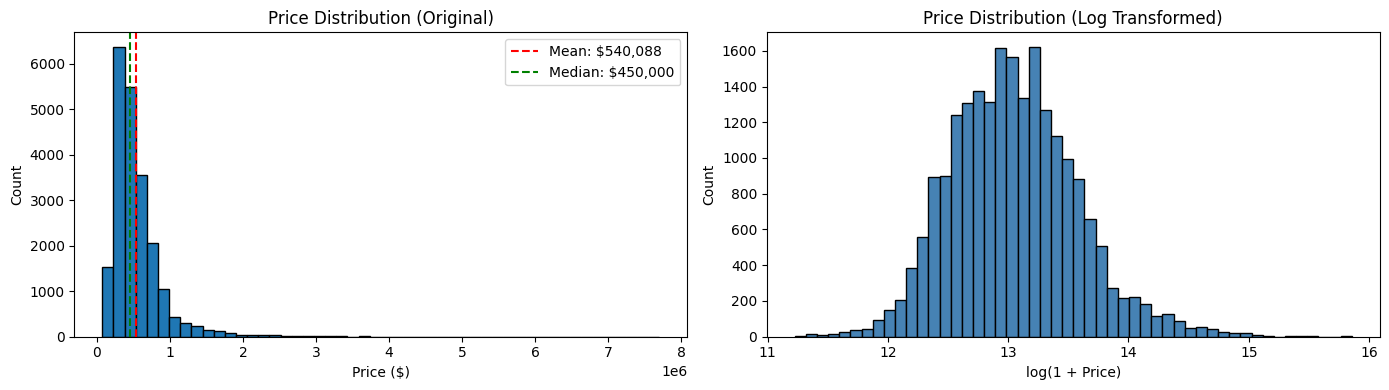

Skewness (original): 4.02
Skewness (log): 0.43


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Original distribution
axes[0].hist(df["price"], bins=50, edgecolor='black')
axes[0].axvline(df["price"].mean(), color='r', linestyle='--', label=f'Mean: ${df["price"].mean():,.0f}')
axes[0].axvline(df["price"].median(), color='g', linestyle='--', label=f'Median: ${df["price"].median():,.0f}')
axes[0].set_xlabel("Price ($)")
axes[0].set_ylabel("Count")
axes[0].set_title("Price Distribution (Original)")
axes[0].legend()

# Log-transformed
axes[1].hist(np.log1p(df["price"]), bins=50, edgecolor='black', color='steelblue')
axes[1].set_xlabel("log(1 + Price)")
axes[1].set_ylabel("Count")
axes[1].set_title("Price Distribution (Log Transformed)")

plt.tight_layout()
plt.show()

print(f"Skewness (original): {df['price'].skew():.2f}")
print(f"Skewness (log): {np.log1p(df['price']).skew():.2f}")

**Observation**: The price distribution is heavily right-skewed (positive skewness), with a long tail of expensive properties. The mean is significantly higher than the median, confirming this asymmetry.

**Implication**: A log transformation could help normalize this distribution. This is relevant for:
1. Linear models that assume normally distributed residuals
2. Features with similar skewed distributions (e.g., square footage variables)

We will apply log transformations during preprocessing.

**Finding**: Price is heavily right-skewed. Log transformation significantly reduces skewness. Consider whether to:
1. Predict log(price) and transform back, or
2. Use models robust to skewed targets (e.g., tree-based)

## 4. Temporal Analysis

In [ ]:
# Parse date column
df["date_parsed"] = pd.to_datetime(df["date"].str[:8], format="%Y%m%d")

print(f"Date range: {df['date_parsed'].min().date()} to {df['date_parsed'].max().date()}")
print(f"Duration: {(df['date_parsed'].max() - df['date_parsed'].min()).days} days")

Date range: 2014-05-02 to 2015-05-27
Duration: 390 days


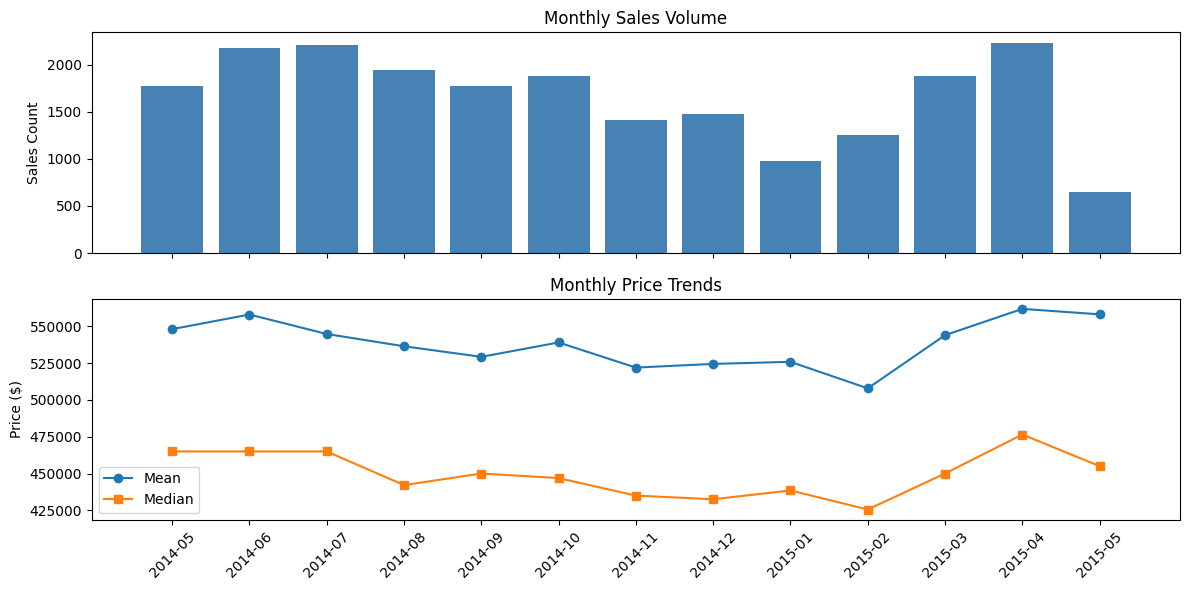

In [ ]:
# Monthly patterns
df["year_month"] = df["date_parsed"].dt.to_period("M")
monthly = df.groupby("year_month").agg(
    count=("price", "count"),
    mean_price=("price", "mean"),
    median_price=("price", "median")
)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].bar(range(len(monthly)), monthly["count"], color="steelblue")
axes[0].set_ylabel("Sales Count")
axes[0].set_title("Monthly Sales Volume")

axes[1].plot(range(len(monthly)), monthly["mean_price"], marker="o", label="Mean")
axes[1].plot(range(len(monthly)), monthly["median_price"], marker="s", label="Median")
axes[1].set_ylabel("Price ($)")
axes[1].set_title("Monthly Price Trends")
axes[1].set_xticks(range(len(monthly)))
axes[1].set_xticklabels([str(p) for p in monthly.index], rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Feature Distributions

### 5.1 Discrete/Ordinal Features

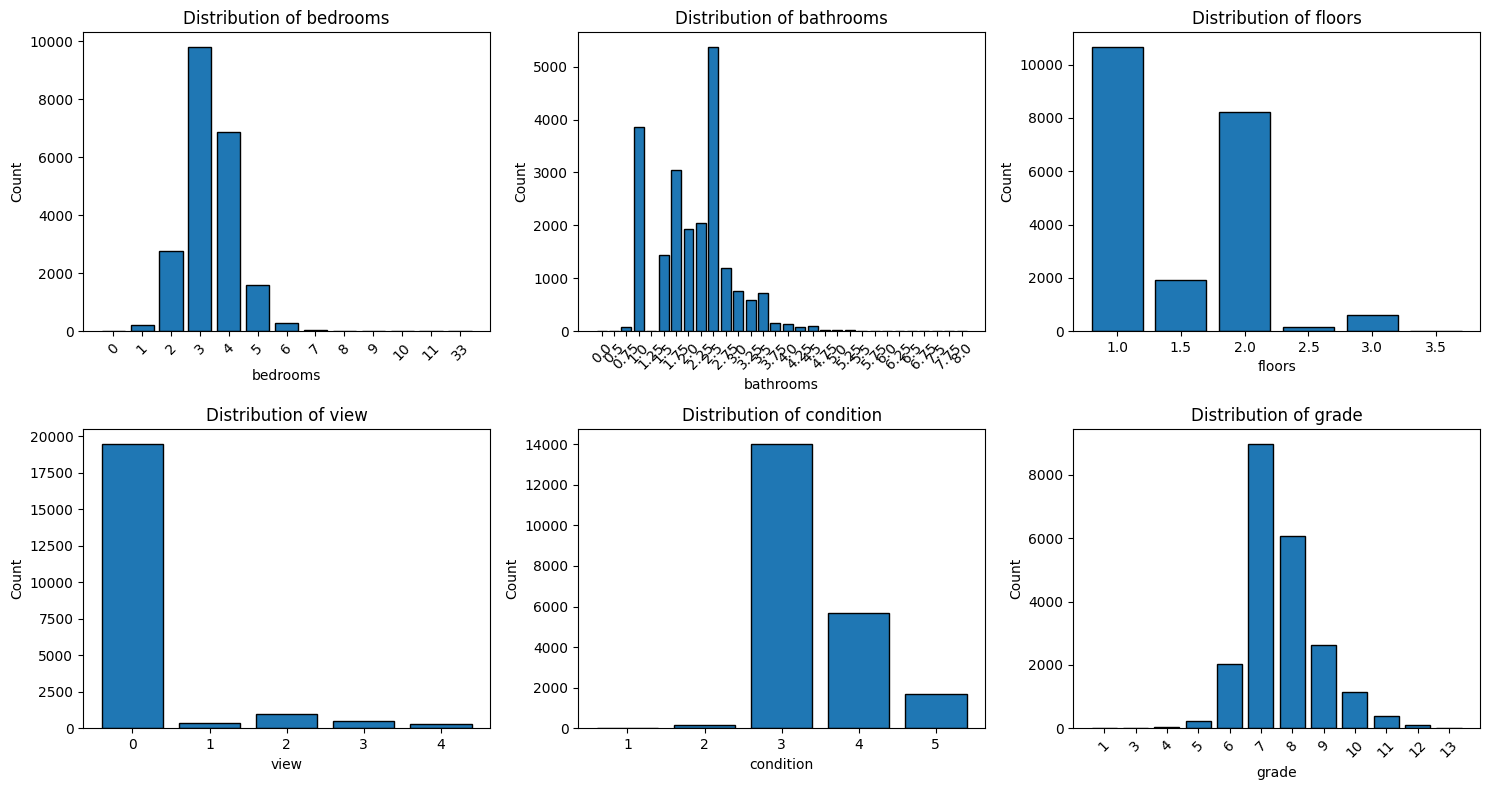

In [ ]:
discrete_features = ["bedrooms", "bathrooms", "floors", "view", "condition", "grade"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, col in zip(axes, discrete_features):
    counts = df[col].value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values, edgecolor='black')
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of {col}")
    if len(counts) > 10:
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Observations on discrete features:**

- **bedrooms**: Most houses have 3-4 bedrooms. There's an extreme outlier with 33 bedrooms (likely a data entry error)
- **bathrooms**: Right-skewed, most have 1-2.5 bathrooms. Half-bathrooms (0.5 increments) are common
- **floors**: Predominantly 1-2 floors, with some 1.5, 2.5, and 3-floor houses
- **view**: Heavily imbalanced — most properties have no view (0). This is essentially a rare positive feature
- **condition**: Roughly normal distribution centered at 3 (average condition)
- **grade**: Most houses fall in grades 7-8, with a slight right skew toward higher quality

### Binary Feature: Waterfront

The `waterfront` column is a binary indicator (0 or 1) representing whether the property has waterfront access.

In [ ]:
waterfront_counts = df["waterfront"].value_counts()
print(f"Waterfront properties: {waterfront_counts.get(1, 0):,} ({100*waterfront_counts.get(1, 0)/len(df):.2f}%)")
print(f"Non-waterfront properties: {waterfront_counts.get(0, 0):,} ({100*waterfront_counts.get(0, 0)/len(df):.2f}%)")

Waterfront properties: 163 (0.75%)
Non-waterfront properties: 21,450 (99.25%)


Waterfront access is a rare but potentially valuable feature. Its impact on price will be examined in the correlation analysis.

### 5.2 Continuous Features (Square Footage)

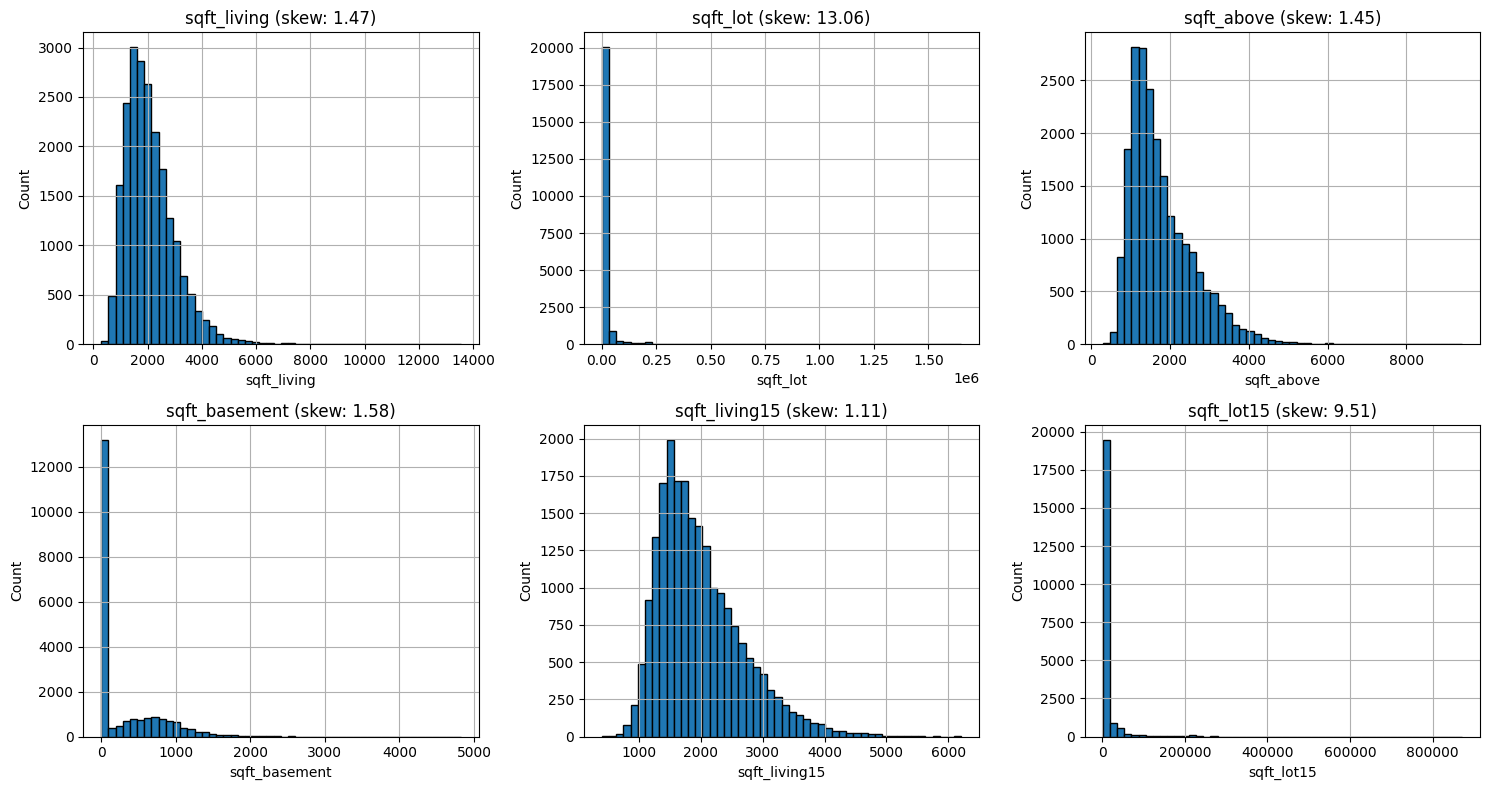

In [ ]:
sqft_features = ["sqft_living", "sqft_lot", "sqft_above", "sqft_basement", "sqft_living15", "sqft_lot15"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, col in zip(axes, sqft_features):
    df[col].hist(bins=50, ax=ax, edgecolor='black')
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    skew = df[col].skew()
    ax.set_title(f"{col} (skew: {skew:.2f})")

plt.tight_layout()
plt.show()

**Finding**: All square footage features are right-skewed. Log transformation is recommended for these features.

### Temporal Features: Year Built and Renovation

Understanding when houses were built and renovated provides context about housing stock age and updates.

In [ ]:
# First, let's examine the yr_renovated column to understand its values
print("Year Renovated - Summary Statistics:")
print(df["yr_renovated"].describe())
print(f"\nUnique values count: {df['yr_renovated'].nunique()}")
print(f"\nValue distribution (showing most common):")
print(df["yr_renovated"].value_counts().head(10))

Year Renovated - Summary Statistics:
count    21613.000000
mean        84.402258
std        401.679240
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

Unique values count: 70

Value distribution (showing most common):
yr_renovated
0       20699
2014       91
2013       37
2003       36
2005       35
2007       35
2000       35
2004       26
1990       25
2006       24
Name: count, dtype: int64


**Interpretation**: The vast majority of houses have `yr_renovated = 0`. Since 0 is not a valid year, this likely indicates "not renovated" rather than a missing value. The non-zero values (ranging from 1934 to 2015) represent actual renovation years. This is a common encoding pattern in real estate datasets.

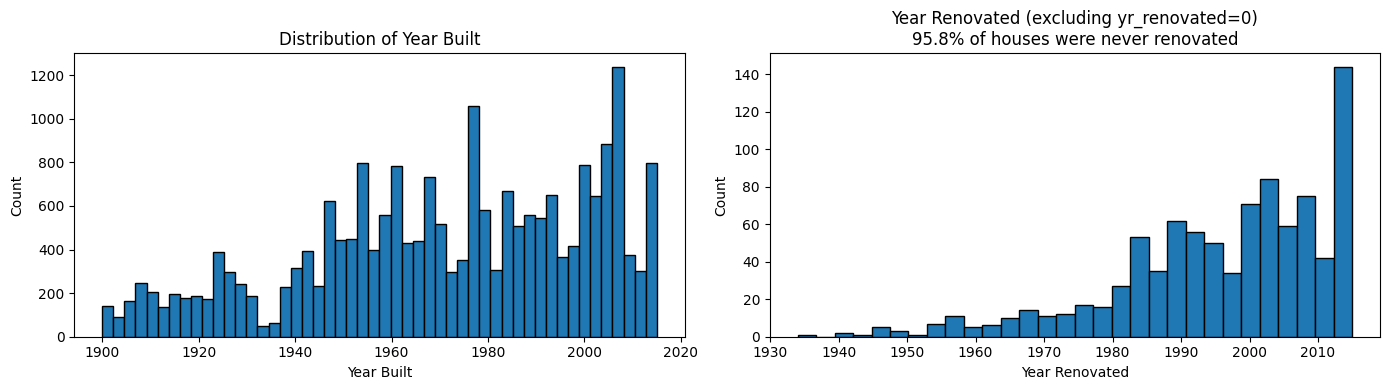

Year built range: 1900 - 2015
Houses with renovation record: 914 (4.2%)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Year built distribution
axes[0].hist(df["yr_built"], bins=50, edgecolor='black')
axes[0].set_xlabel("Year Built")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Year Built")

# Year renovated - filter out zeros (non-renovated houses) to see actual renovation years
renovated = df[df["yr_renovated"] > 0]["yr_renovated"]
not_renovated_pct = 100 * (len(df) - len(renovated)) / len(df)

axes[1].hist(renovated, bins=30, edgecolor='black')
axes[1].set_xlabel("Year Renovated")
axes[1].set_ylabel("Count")
axes[1].set_title(f"Year Renovated (excluding yr_renovated=0)\n{not_renovated_pct:.1f}% of houses were never renovated")

plt.tight_layout()
plt.show()

print(f"Year built range: {df['yr_built'].min()} - {df['yr_built'].max()}")
print(f"Houses with renovation record: {len(renovated):,} ({100*len(renovated)/len(df):.1f}%)")

**Observations:**

- **Year built**: Houses span from 1900 to 2015. There's increased construction activity post-1940s and notable peaks around 1960s and 2000s
- **Year renovated**: Most houses (>95%) have never been renovated (yr_renovated = 0). For those renovated, activity peaked in the 2000s

**Feature engineering idea**: Create a binary `is_renovated` feature, or compute `years_since_renovation` (using sale date).

### High-Cardinality Categorical: Zipcode

Zipcode is stored as a number but is actually categorical. Let's understand its cardinality and distribution.

In [ ]:
print(f"Number of unique zipcodes: {df['zipcode'].nunique()}")
print(f"\nSales per zipcode (top 10):")
print(df["zipcode"].value_counts().head(10))
print(f"\nSales per zipcode (bottom 5):")
print(df["zipcode"].value_counts().tail(5))

Number of unique zipcodes: 70

Sales per zipcode (top 10):
zipcode
98103    602
98038    590
98115    583
98052    574
98117    553
98042    548
98034    545
98118    508
98023    499
98006    498
Name: count, dtype: int64

Sales per zipcode (bottom 5):
zipcode
98102    105
98010    100
98024     81
98148     57
98039     50
Name: count, dtype: int64


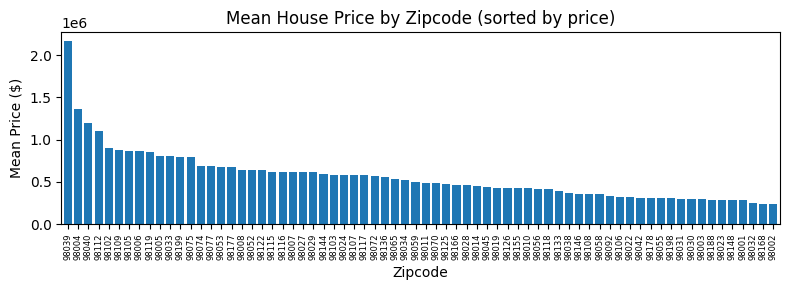


Price range across zipcodes:
  Highest avg price: 98039 ($2,160,607)
  Lowest avg price: 98002 ($234,284)


In [ ]:
# Mean price by zipcode
zipcode_price = df.groupby("zipcode")["price"].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 3))
zipcode_price.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel("Zipcode")
ax.set_ylabel("Mean Price ($)")
ax.set_title("Mean House Price by Zipcode (sorted by price)")
ax.tick_params(axis='x', rotation=90, labelsize=6)
plt.tight_layout()
plt.show()

print(f"\nPrice range across zipcodes:")
print(f"  Highest avg price: {zipcode_price.idxmax()} (${zipcode_price.max():,.0f})")
print(f"  Lowest avg price: {zipcode_price.idxmin()} (${zipcode_price.min():,.0f})")

**Observations:**

- **70 unique zipcodes** — too many for one-hot encoding (would add 69 features)
- Strong price variation across zipcodes — location clearly matters
- Some zipcodes have very few samples

**Preprocessing options:**
1. **Drop zipcode**: Use lat/long instead (continuous, captures location)
2. **Geographic clustering**: Group coordinates into clusters that may capture price-based patterns
3. **Keep for tree models**: Tree-based models can handle high-cardinality categoricals directly

Since we have lat/long coordinates, we'll rely on geographic clustering rather than zipcode encoding.

## 6. Correlation Analysis

In [ ]:
# Correlations with price
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlations = df[numeric_cols].corr()["price"].sort_values(ascending=False)

print("Correlations with price:")
print(correlations)

Correlations with price:
price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64


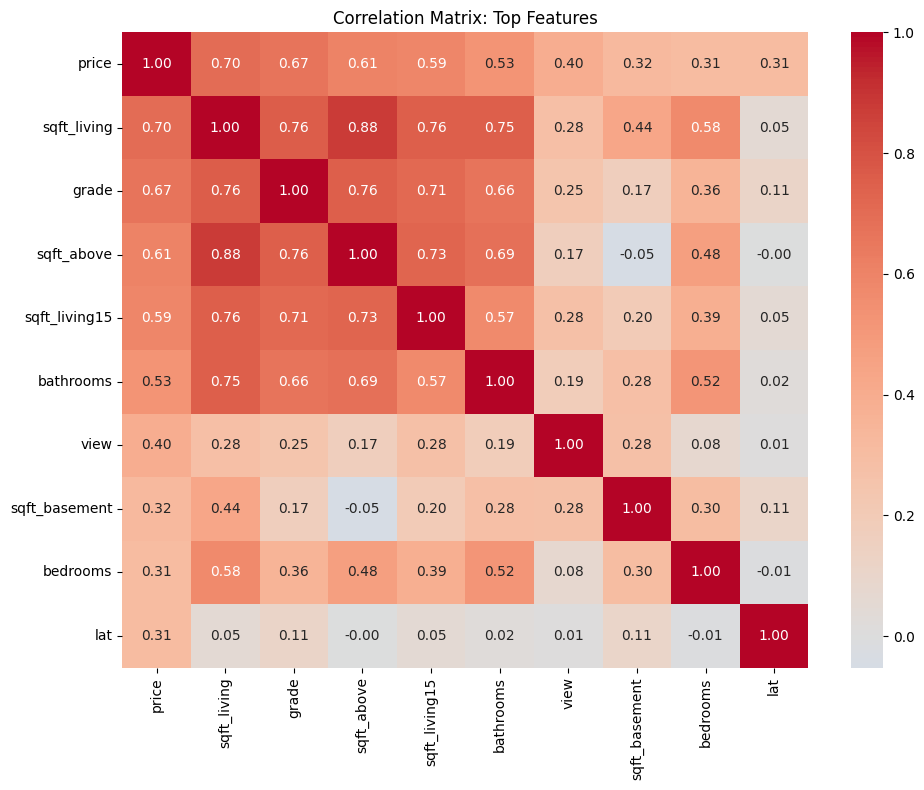

In [ ]:
# Correlation heatmap for top features
top_features = correlations.abs().nlargest(10).index.tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(df[top_features].corr(), annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Matrix: Top Features")
plt.tight_layout()
plt.show()

**Key correlations**:
- `sqft_living` (0.70) — strongest predictor
- `grade` (0.67) — construction quality
- `sqft_above` (0.61) — above-ground area
- High multicollinearity between sqft features (expected)

## 7. Geographic Analysis

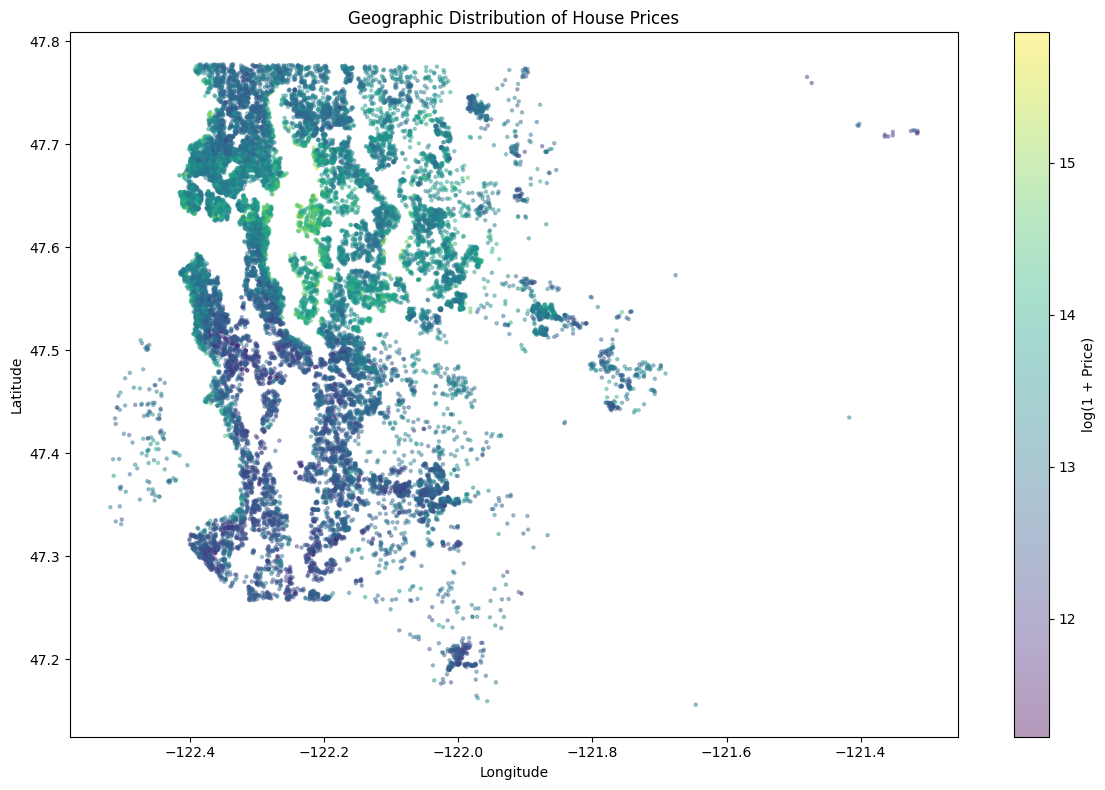

In [ ]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df["long"], df["lat"],
    c=np.log1p(df["price"]),
    cmap="viridis",
    alpha=0.4,
    s=5
)
plt.colorbar(scatter, label="log(1 + Price)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of House Prices")
plt.tight_layout()
plt.show()

**Finding**: Clear geographic price patterns. Certain areas (waterfront, urban centers) have consistently higher prices. Geographic clustering could capture these patterns.

## Feature-Target Relationships

Let's visualize how the most predictive features relate to price.

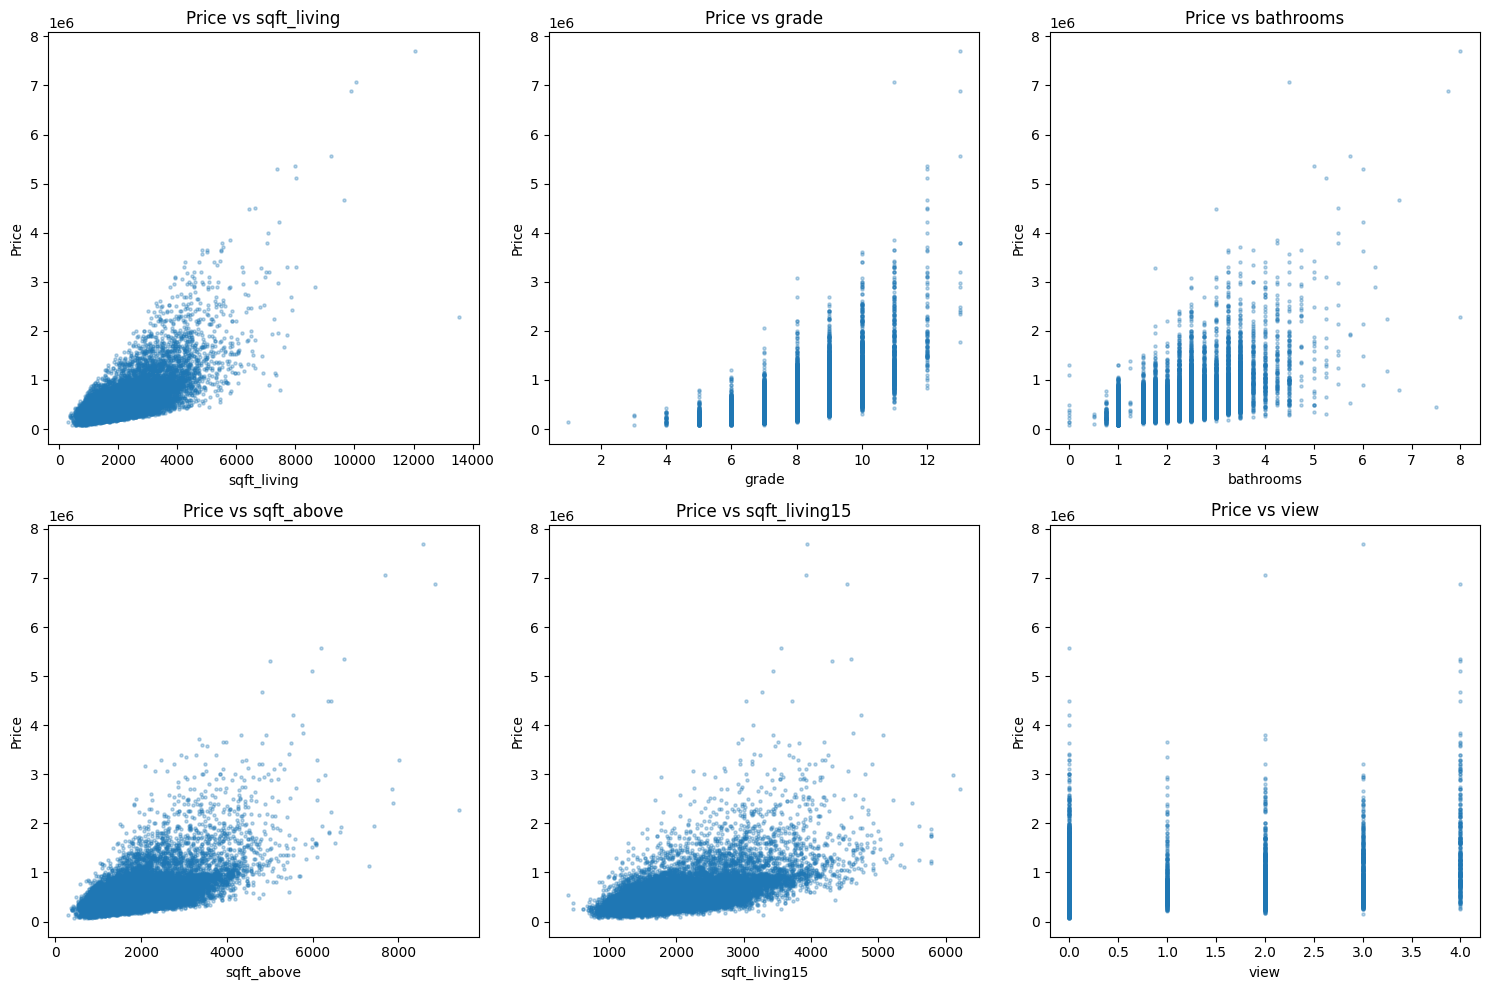

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

features_to_plot = ["sqft_living", "grade", "bathrooms", "sqft_above", "sqft_living15", "view"]
for ax, feat in zip(axes.flatten(), features_to_plot):
    ax.scatter(df[feat], df["price"], alpha=0.3, s=5)
    ax.set_xlabel(feat)
    ax.set_ylabel("Price")
    ax.set_title(f"Price vs {feat}")

plt.tight_layout()
plt.show()

**Observations:**
- `sqft_living`: Clear positive relationship but with increasing variance at higher values (heteroscedasticity)
- `grade`: Strong step-wise pattern — grade is highly predictive
- `bathrooms`: Positive relationship with some outliers
- `view`: Higher view ratings associated with higher prices, but most properties have view=0

## Potential Feature Engineering

Based on domain knowledge and EDA findings, let's explore some potential engineered features.

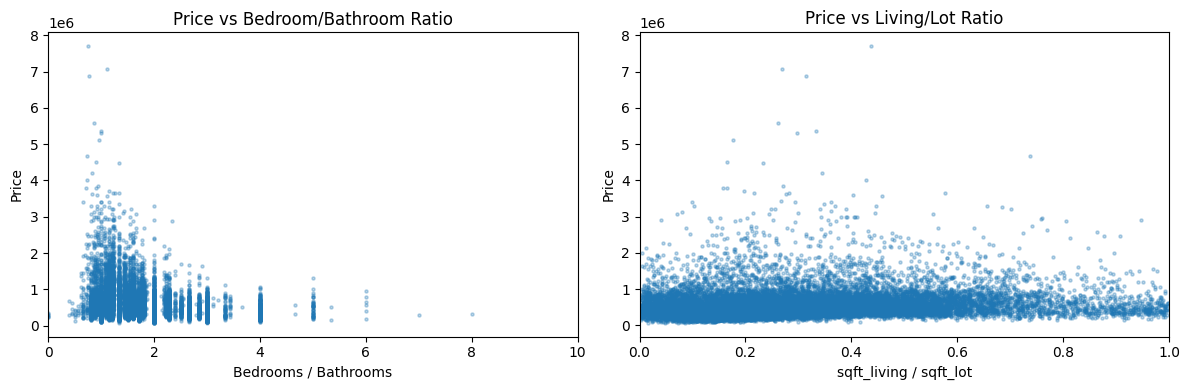

Correlation of bed/bath ratio with price: -0.249
Correlation of living/lot ratio with price: 0.123


In [ ]:
# Explore potential ratio features
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bedroom to bathroom ratio
bed_bath_ratio = df["bedrooms"] / df["bathrooms"].replace(0, np.nan)
axes[0].scatter(bed_bath_ratio, df["price"], alpha=0.3, s=5)
axes[0].set_xlabel("Bedrooms / Bathrooms")
axes[0].set_ylabel("Price")
axes[0].set_title("Price vs Bedroom/Bathroom Ratio")
axes[0].set_xlim(0, 10)  # Limit x-axis for better visualization

# Living to lot ratio
living_lot_ratio = df["sqft_living"] / df["sqft_lot"].replace(0, np.nan)
axes[1].scatter(living_lot_ratio, df["price"], alpha=0.3, s=5)
axes[1].set_xlabel("sqft_living / sqft_lot")
axes[1].set_ylabel("Price")
axes[1].set_title("Price vs Living/Lot Ratio")
axes[1].set_xlim(0, 1)  # Most values are below 1

plt.tight_layout()
plt.show()

print(f"Correlation of bed/bath ratio with price: {bed_bath_ratio.corr(df['price']):.3f}")
print(f"Correlation of living/lot ratio with price: {living_lot_ratio.corr(df['price']):.3f}")

**Ratio feature observations:**
- Bedroom/bathroom ratio shows some pattern but weak correlation
- Living/lot ratio might capture property density information

These ratios may provide marginal value and are worth including in the preprocessing pipeline.

## Summary: EDA Findings

### Data Quality
- **No missing values** in the dataset
- **`date` column**: String format, can extract year/month for temporal features
- **`zipcode`**: Numeric but categorical in nature; latitude/longitude provide better geographic info

### Target Variable
- **Price is right-skewed** (skewness > 2)
- Log transformation normalizes the distribution
- Consider whether to predict log(price) and inverse transform, or use models robust to skewness

### Feature Transformations
- **Apply log transformation to**: `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`, `sqft_living15`, `sqft_lot15`
- **Standard scaling** for other numeric features

### Feature Engineering
- **Geographic clustering**: Use K-means on (lat, long) to capture neighborhood effects
- **Ratio features**: bedroom/bathroom ratio, living/lot ratio may add value
- **Temporal features**: Extract sale year and month from date

### Model Selection Considerations
- Strong linear relationships with some features → Linear models can work as baseline
- Complex geographic patterns → Tree-based models (Random Forest, Gradient Boosting) likely to perform better
- Multicollinearity present → Less concern for tree-based models

### Features to Drop
- `id`: Not predictive
- `date`: Replace with extracted year/month
- `zipcode`: Redundant with lat/long coordinates

### Temporal Patterns
- Prices vary over time
- **Critical**: Requires temporal train/test split
- See `p3-03-temporal_leakage.ipynb`

### Repeated Property IDs
- ~0.85% of records have repeated IDs
- These are valid resale transactions
- See `p3-02-repeated_ids.ipynb`
